In [76]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from utils.utils import *
from pandas import json_normalize

import warnings
warnings.filterwarnings('ignore')

In [73]:
def process_json(file_path):
    data_df = pd.read_json(file_path)
    data_df['cleaned_text'] = data_df['text'].apply(replace_newlines_with_fullstop)
    if 'link' in data_df.columns:
        data_df.drop(columns=['link'], inplace=True)
    
    return data_df

In [80]:
def show_distribution(file_path, tag='Predictions'):

    # Open the JSON file and load it into a variable
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    data = json_normalize(data)
    label_counts = Counter(label for labels in data['labels'] for label in labels)

    # Convert the counter to a DataFrame for better visualization
    label_distribution = pd.DataFrame(label_counts.items(), columns=['Label', 'Count']).sort_values(by='Count', ascending=False)
    
    # Set the visualization style
    sns.set(style="whitegrid")
    
    # Create a bar plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Count', y='Label', data=label_distribution, palette='viridis')
    ax.set_title('Distribution of Labels')
    ax.set_xlabel('Count')
    ax.set_ylabel('Label')
    ax.set_title(f'Distribution of {tag} Labels')
    
    # Show the plot
    plt.show()

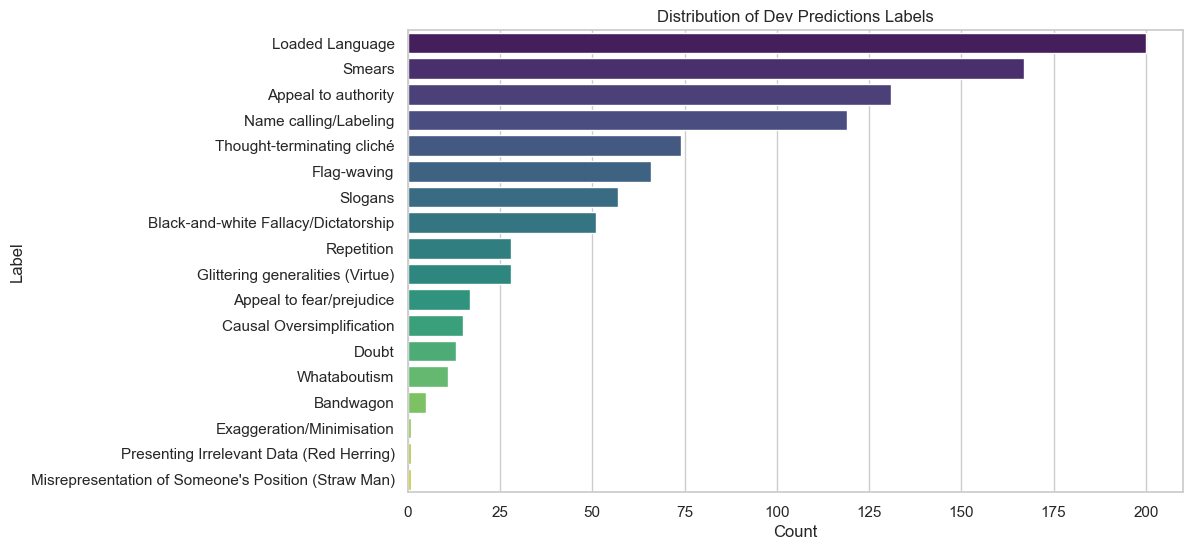

In [83]:
show_distribution('./Predictions/mBERT_en_dev_predictions_subtask1.txt', 'Dev Predictions')

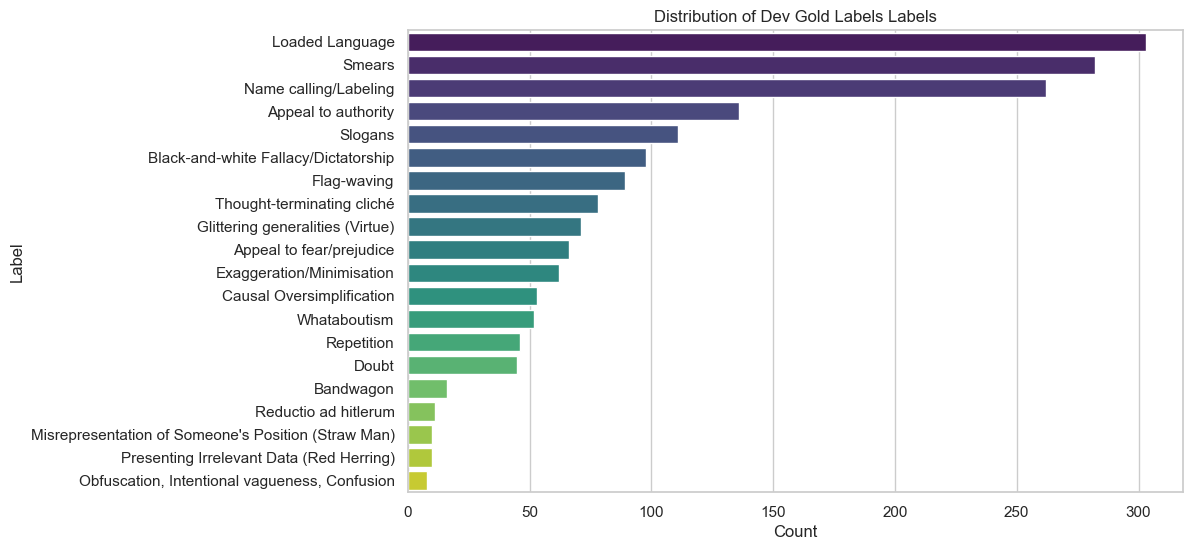

In [84]:
show_distribution('./dev_gold_labels/dev_subtask1_en.json', 'Dev Gold Labels')

In [141]:


# Step 1: Load the actual labels from the JSON file
def load_actual_labels(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

# Step 2: Load the predicted labels from the TXT file
def load_predicted_labels(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)
    
    
# Step 3: Create a dataframe for misclassified instances
def find_misclassified_instances(actual_data, predicted_data):
    # Create dataframes
    df_actual = pd.DataFrame(actual_data)
    df_predicted = pd.DataFrame(predicted_data)
    
    # Merge dataframes on the 'id' field
    df_merged = pd.merge(df_actual, df_predicted, on='id', suffixes=('_actual', '_predicted'))
    
    # Find misclassified instances
    misclassified = df_merged[df_merged['labels_actual'] != df_merged['labels_predicted']]
    correctly_classified = df_merged[df_merged['labels_predicted'] == df_merged['labels_actual']]
    
    cols = ['id', 'labels_actual', 'labels_predicted']
    
    return correctly_classified[cols], misclassified[cols], df_merged

from collections import defaultdict

def calculate_confusion_details_freq(df):
    confusion_details = defaultdict(lambda: defaultdict(int))

    # Iterate over each row and record confusions
    for _, row in df.iterrows():
        actual_labels = set(row['labels_actual'])
        predicted_labels = set(row['labels_predicted'])
        
        intersection = actual_labels.intersection(predicted_labels)
        
        actual_labels = actual_labels - intersection
        predicted_labels = predicted_labels - intersection
        
        if len(actual_labels) == 0 and len(predicted_labels) > 0:
            actual_labels = set(['Extra Label'])
            
        if len(predicted_labels) == 0 and len(actual_labels) > 0 and 'Extra Label' not in actual_labels:
            predicted_labels = set(['Missed'])

        # Record false positives for actual labels (incorrectly predicted labels)
        for predicted_label in predicted_labels:
            if predicted_label not in actual_labels:
                for actual_label in actual_labels:
                    confusion_details[actual_label][predicted_label] += 1

        # Record false negatives for actual labels (missed labels)
        for actual_label in actual_labels:
            if actual_label not in predicted_labels:
                confusion_details[actual_label]['FN'] += 1

    # Flatten the confusion details into a list of tuples
    confusion_data = []
    for actual_label, predicted_dict in confusion_details.items():
        for predicted_label, count in predicted_dict.items():
            confusion_data.append({
                'Actual Label': actual_label,
                'Predicted Label': predicted_label,
                'Frequency': count
            })

    return pd.DataFrame(confusion_data)
    

def show_confused_labels_freq(gold_file, predictions_file):
    # Replace 'path_to_actual' and 'path_to_predicted' with the actual file paths
    actual_labels = load_actual_labels(gold_file)
    predicted_labels = load_predicted_labels(predictions_file)
    
    # Find misclassified instances
    correctly_classified, misclassified, total_data = find_misclassified_instances(actual_labels, predicted_labels)
    
    confusion_df = calculate_confusion_details_freq(total_data)

    # Now sort by 'Frequency' and get the top 5 most confused label pairs
    confusion_df = confusion_df[confusion_df['Predicted Label'] != 'FN']  # Exclude the false negatives from this particular count
    confusion_df = confusion_df.sort_values(by='Frequency', ascending=False).head(40)
    
    top_confusions = confusion_df  # Ensure this contains only the top 5 if it's not pre-filtered
    
    # print(top_confusions)

    # Set a theme and palette for a more aesthetically pleasing look
    sns.set(style="whitegrid")
    palette = sns.color_palette("pastel", n_colors=top_confusions['Predicted Label'].nunique())
    
    # Create a bar plot for the most confused label pairs
    plt.figure(figsize=(12, 8))
    bar = sns.barplot(x='Frequency', y='Actual Label', hue='Predicted Label', data=top_confusions, dodge=False, palette=palette)
    plt.title('Top Most Confused Labels', fontsize=16)
    plt.xlabel('Frequency of Confusion', fontsize=14)
    plt.ylabel('Actual Label', fontsize=14)
    
    # Annotate the bars with the frequency value
    for p in bar.patches:
        pass
        # bar.annotate(format(p.get_width(), '.0f'), 
        #              (p.get_width(), p.get_y() + p.get_height() / 2.), 
        #              ha = 'center', va = 'center', 
        #              xytext = (15, 0), 
        #              textcoords = 'offset points',
        #              fontsize=5
        #              )
    
    # Adjust legend
    plt.legend(title='Predicted Label', fontsize=9, title_fontsize='11', loc='lower right', bbox_to_anchor=(1, -0.2))
    
    # Further style improvements
    sns.despine(left=True, bottom=True)  # Remove the top and right spines
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    return top_confusions

In [134]:
def calculate_confusion_details_percentage(df):
    confusion_details = defaultdict(lambda: defaultdict(int))
    label_totals = defaultdict(int)

    # Iterate over each row and record confusions
    for _, row in df.iterrows():
        actual_labels = set(row['labels_actual'])
        predicted_labels = set(row['labels_predicted'])

        # Record occurrences of each actual label
        for actual_label in actual_labels:
            label_totals[actual_label] += 1
            
        intersection = actual_labels.intersection(predicted_labels)
        
        actual_labels = actual_labels - intersection
        predicted_labels = predicted_labels - intersection
        
        if len(actual_labels) == 0 and len(predicted_labels) > 0:
            actual_labels = set(['Extra Label'])
            label_totals['Extra Label'] += len(predicted_labels)
            
        if len(predicted_labels) == 0 and len(actual_labels) > 0 and 'Extra Label' not in actual_labels:
            predicted_labels = set(['Missed'])
            label_totals['Missed'] += len(actual_labels)

        # Record false positives for actual labels (incorrectly predicted labels)
        for predicted_label in predicted_labels:
            if predicted_label not in actual_labels:
                for actual_label in actual_labels:
                    confusion_details[actual_label][predicted_label] += 1

        # Record false negatives for actual labels (missed labels)
        for actual_label in actual_labels:
            if actual_label not in predicted_labels:
                confusion_details[actual_label]['FN'] += 1

    # Calculate percentages
    confusion_data = []
    for actual_label, predicted_dict in confusion_details.items():
        for predicted_label, count in predicted_dict.items():
            percentage = (count / label_totals[actual_label]) * 100
            confusion_data.append({
                'Actual Label': actual_label,
                'Predicted Label': predicted_label,
                'Percentage': percentage
            })

    return pd.DataFrame(confusion_data)


def show_confused_labels_percentage(gold_file, predictions_file):
    actual_labels = load_actual_labels(gold_file)
    predicted_labels = load_predicted_labels(predictions_file)
    
    correctly_classified, misclassified, total_data = find_misclassified_instances(actual_labels, predicted_labels)
    
    confusion_df = calculate_confusion_details_percentage(total_data)

    # Filter to remove false negatives and sort by 'Percentage'
    confusion_df = confusion_df[confusion_df['Predicted Label'] != 'FN']
    confusion_df = confusion_df.sort_values(by='Percentage', ascending=False).head(40)
    
    top_confusions = confusion_df  # Ensure this contains only the top 5 if it's not pre-filtered

    sns.set(style="whitegrid")
    
    palette = sns.color_palette("pastel", n_colors=top_confusions['Predicted Label'].nunique())
    
    plt.figure(figsize=(12, 8))
    bar = sns.barplot(x='Percentage', y='Actual Label', hue='Predicted Label', data=top_confusions, dodge=False, palette=palette)
    plt.title('Top Most Confused Labels (Percentage)', fontsize=16)
    plt.xlabel('Percentage of Confusion', fontsize=14)
    plt.ylabel('Actual Label', fontsize=14)
    
    for p in bar.patches:
        bar.annotate(f"{p.get_width():.1f}%", 
                     (p.get_width(), p.get_y() + p.get_height() / 2.), 
                     ha = 'center', va = 'center', 
                     xytext = (20, 0),
                     textcoords = 'offset points',
                     )

    plt.legend(title='Predicted Label', fontsize=9, title_fontsize='11', loc='lower right', bbox_to_anchor=(1, -0.2))
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    
    plt.show()


### Baseline subtask-1 analysis

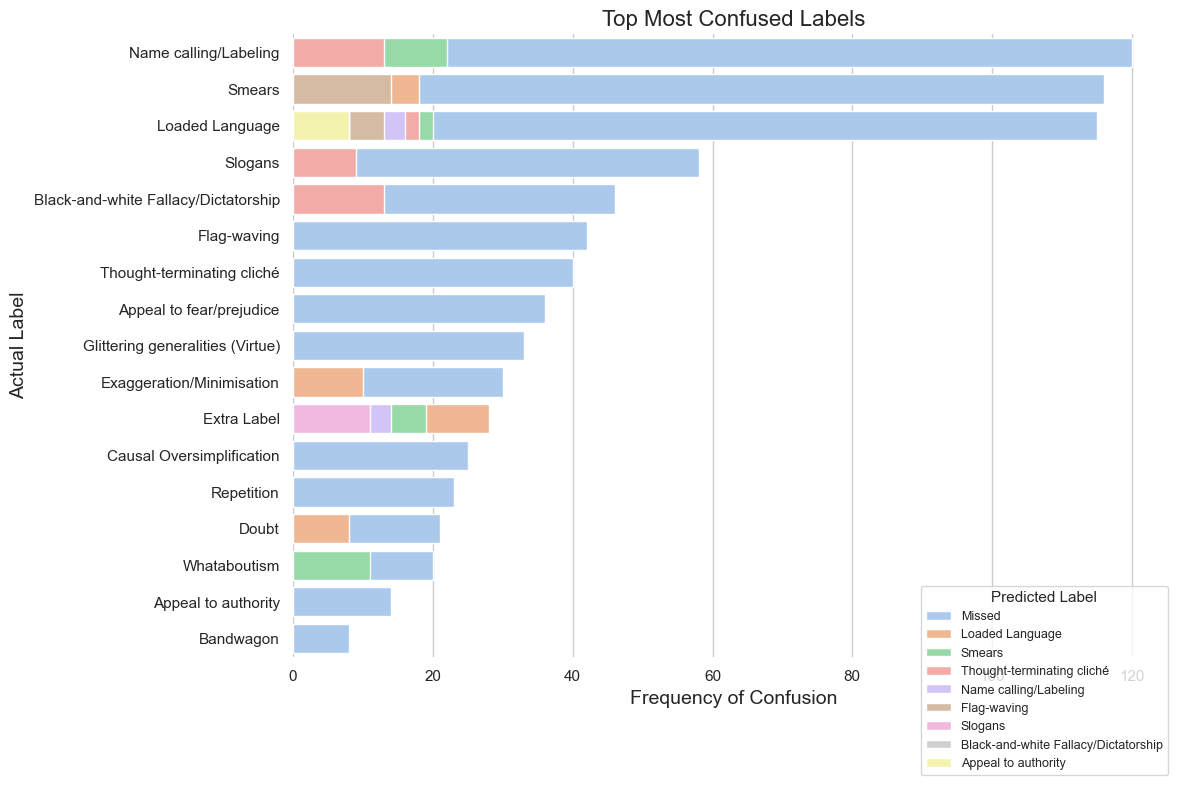

In [142]:
top_confusions = show_confused_labels_freq('./dev_gold_labels/dev_subtask1_en.json',
                     './Predictions/mBERT_en_dev_predictions_subtask1.txt')

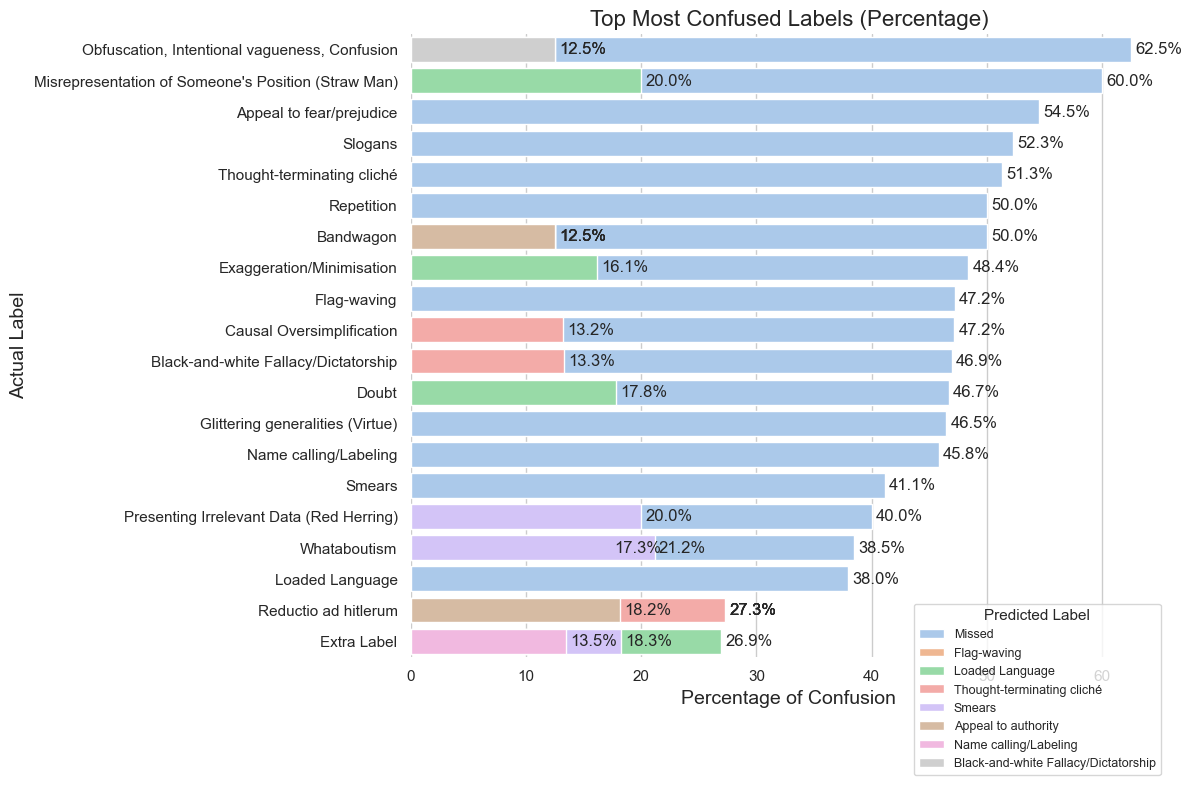

In [136]:
show_confused_labels_percentage('./dev_gold_labels/dev_subtask1_en.json',
                     './Predictions/mBERT_en_dev_predictions_subtask1.txt')

### Ensemble (best model) subtask-1 analysis

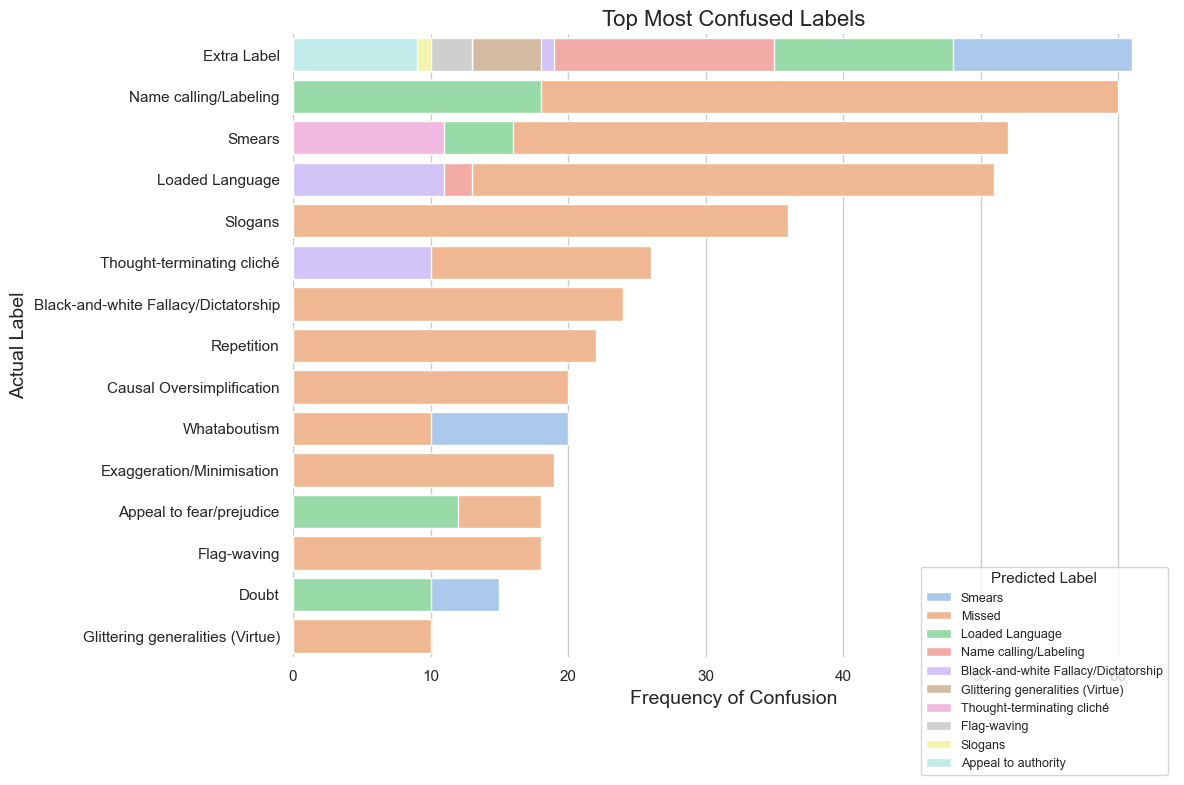

In [137]:
show_confused_labels_freq('./dev_gold_labels/dev_subtask1_en.json',
                     './Predictions/ensemble_en_dev_predictions_subtask1.txt')

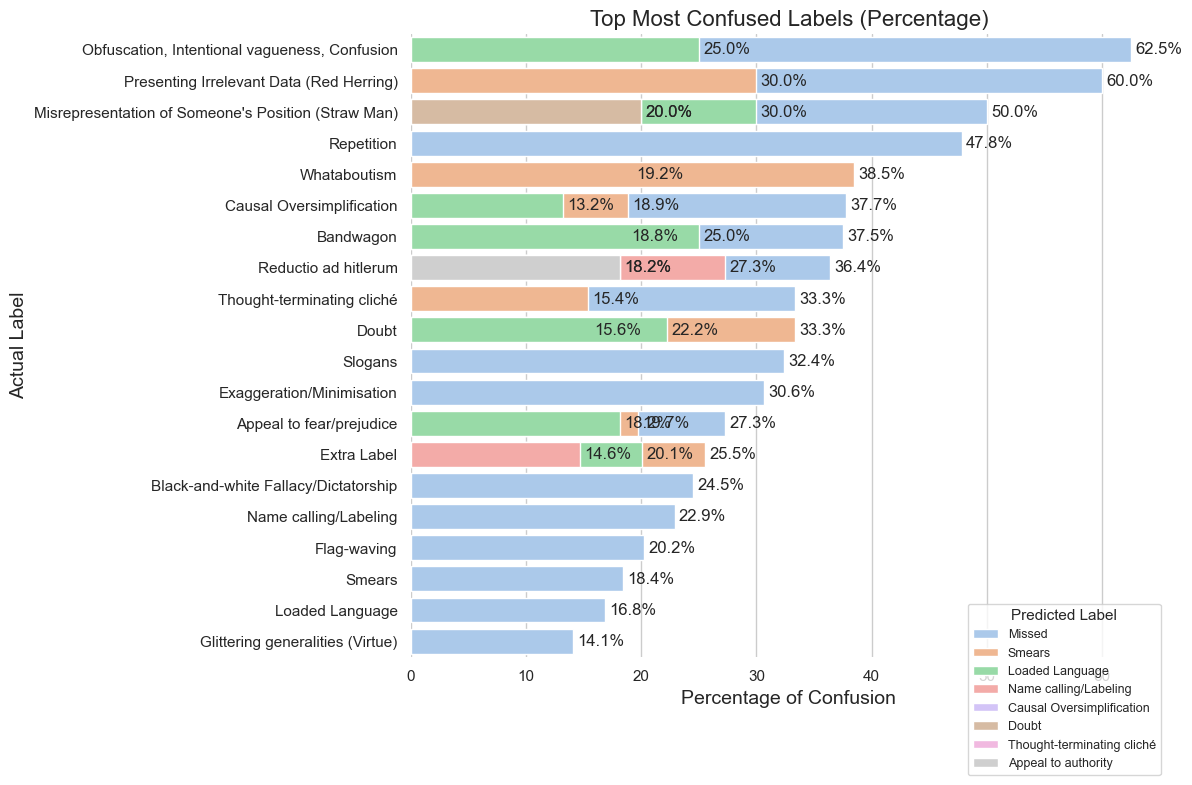

In [138]:
show_confused_labels_percentage('./dev_gold_labels/dev_subtask1_en.json',
                     './Predictions/ensemble_en_dev_predictions_subtask1.txt')